In [216]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 



In [217]:
df_bank = pd.read_csv('df_bank_con_out_sel.csv')
df_bank.head()


,housing,previous,balance,campaign,deposit,cat_poutcome_failure,cat_poutcome_success
0,1,0,2343,1,1,False,False
1,0,0,45,1,1,False,False
2,1,0,1270,1,1,False,False
3,1,0,2476,1,1,False,False
4,0,0,184,2,1,False,False


In [218]:
df_bank['cat_poutcome_failure']=df_bank['cat_poutcome_failure'].astype('int64')
df_bank['cat_poutcome_success']=df_bank['cat_poutcome_success'].astype('int64')
df_bank

,housing,previous,balance,campaign,deposit,cat_poutcome_failure,cat_poutcome_success
0,1,0,2343,1,1,0,0
1,0,0,45,1,1,0,0
2,1,0,1270,1,1,0,0
3,1,0,2476,1,1,0,0
4,0,0,184,2,1,0,0
...,...,...,...,...,...,...,...
11157,1,0,1,1,0,0,0
11158,0,0,733,4,0,0,0
11159,0,0,29,2,0,0,0
11160,0,5,0,2,0,1,0


Hemos realizado la conversión de False a 0 y de True a 1 con astype, porque en el foro alguien comentó que le fallaba la aplicación con one hot coding. Y para evitar futuros errores
la codifico como un int64. La codifico como un int64 tal como lo están todas, y así es homogéneo.

In [219]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   housing               11162 non-null  int64
 1   previous              11162 non-null  int64
 2   balance               11162 non-null  int64
 3   campaign              11162 non-null  int64
 4   deposit               11162 non-null  int64
 5   cat_poutcome_failure  11162 non-null  int64
 6   cat_poutcome_success  11162 non-null  int64
dtypes: int64(7)
memory usage: 610.6 KB


El modelo ganador tenía las siguientes características predictivas: **housing, balance y cat_poutcome_success**

In [220]:
col_entrenadas=['housing','balance','cat_poutcome_success']
X=df_bank[col_entrenadas]
X


,housing,balance,cat_poutcome_success
0,1,2343,0
1,0,45,0
2,1,1270,0
3,1,2476,0
4,0,184,0
...,...,...,...
11157,1,1,0
11158,0,733,0
11159,0,29,0
11160,0,0,0


In [221]:
y=df_bank['deposit']
y

0        1
1        1
2        1
3        1
4        1
        ..
11157    0
11158    0
11159    0
11160    0
11161    0
Name: deposit, Length: 11162, dtype: int64

In [238]:
#Guardamos el dataset con las características X de las variables seleccionadas, ya winsorizadas pero sin escalar. 
X.to_csv('X_bank.csv', index=False)
#Guardamos la variable objetivo 
y.to_csv('y_bank.csv', index=False)

**Winsorización antes del escalado**

In [222]:
# Para tratar los outliers se aplicará la técnica de Winsorización para mantener la estructura del dataset
# Función para calcular límites IQR
def calculate_iqr_limits(df, columns):
    limits_dict = {}
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        limits_dict[column] = (lower_bound, upper_bound)
        
    return limits_dict

# Función para winsorizar datos
def winsorize_data(df, columns):
    limits_dict = calculate_iqr_limits(df, columns)
    
    for column, (lower_bound, upper_bound) in limits_dict.items():
        # Winsorizar: Reemplazar valores menores que el límite inferior y mayores que el límite superior
        df[column] = np.clip(df[column], lower_bound, upper_bound)
        
    return df

X=X.copy() #Así evito el warning
# Aplicar winsorización a las columnas especificadas (las numéricas)
columns_to_check=['balance']
X = winsorize_data(X, columns_to_check)


In [237]:
X

,housing,balance,cat_poutcome_success
0,1,2343,0
1,0,45,0
2,1,1270,0
3,1,2476,0
4,0,184,0
...,...,...,...
11157,1,1,0
11158,0,733,0
11159,0,29,0
11160,0,0,0


In [ ]:
X.describe()

,housing,balance,cat_poutcome_success
count,11162.000000,11162.000000,11162.000000
mean,0.473123,1117.352804,0.095951
std,0.499299,1349.670734,0.294537
min,0.000000,-2257.000000,0.000000
25%,0.000000,122.000000,0.000000
50%,0.000000,550.000000,0.000000
75%,1.000000,1708.000000,0.000000
max,1.000000,4087.000000,1.000000


**Escalado de las columnas numéricas**

In [224]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   housing               11162 non-null  int64
 1   balance               11162 non-null  int64
 2   cat_poutcome_success  11162 non-null  int64
dtypes: int64(3)
memory usage: 261.7 KB


In [225]:
# Escalador para estandarizar los datos
scaler = StandardScaler()

balance_np=X['balance'].values

#X[columns_to_standardize] = scaler.fit_transform(X[columns_to_standardize].values. Esta versión funcionaba, pero el scaler, entendría que le había pasado 3 columnas. Y 
#cuando escalo la variable balance, para nuevos datos de la fase de predicción, da error, porque espera tres columnas. Por eso que el escalado sea de una única variable. 
balance_standarized= scaler.fit_transform(balance_np.reshape(-1,1))
balance_standarized


array([[ 0.90814898],
       [-0.79456479],
       [ 0.11310465],
       ...,
       [-0.80642006],
       [-0.82790775],
       [-0.82790775]])

In [228]:
#Guardamos el dataset en X_scaled que es más común
X_scaled=X.copy()
X_scaled['balance']=balance_standarized
X_scaled

,housing,balance,cat_poutcome_success
0,1,0.908149,0
1,0,-0.794565,0
2,1,0.113105,0
3,1,1.006696,0
4,0,-0.691572,0
...,...,...,...
11157,1,-0.827167,0
11158,0,-0.284788,0
11159,0,-0.806420,0
11160,0,-0.827908,0


**Solo le pasaremos numpy arrays al modelo**

In [229]:
#Le passaremos directamente un numpy al modelo de regresión logística, para que así no le transfiera los nombres de columnas y evitar problemas al ejectuar app.py
X_scaled_np=X_scaled.values
X_scaled_np

array([[ 1.        ,  0.90814898,  0.        ],
       [ 0.        , -0.79456479,  0.        ],
       [ 1.        ,  0.11310465,  0.        ],
       ...,
       [ 0.        , -0.80642006,  0.        ],
       [ 0.        , -0.82790775,  0.        ],
       [ 0.        , -0.82790775,  0.        ]])

In [230]:
y_np=y.values
y_np

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

**Entrenamos el modelo**

In [231]:
#Cogemos los parámetros que nos fueron bien
modelo_regres_logistica = linear_model.LogisticRegression(C=0.1, penalty='l1', max_iter=100, solver='liblinear')
#Al pasarle X_scaled.values, le esto y pasando los valores en un np.array y de esta manera, no le estoy pasando el nombre de las columnas
#Sinó luego me fallaba al cargar el modelo
modelo_regres_logistica.fit(X_scaled_np,y_np)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [240]:
print("Media:", scaler.mean_)
print("Escala:", scaler.scale_)
print("balance_standarized:", balance_standarized)
print("Escala:", scaler.scale_)

Media: [1117.35280416]
Escala: [1349.61027399]
balance_standarized: [[ 0.90814898]
 [-0.79456479]
 [ 0.11310465]
 ...
 [-0.80642006]
 [-0.82790775]
 [-0.82790775]]
Escala: [1349.61027399]


**Queremos ver las nuevas métricas entrenando con el 100% del dataset**

Este punto no haría falta, lo hacemos por curiosidad. Vemos que al final se ha reducido, un poco las métricas, pero no es normal porque tenemos muchos más datos para ajustar.

In [241]:
#Función para calcular todas las métricas de evaluación del modelo de clasificación a partir de las clases reales y predichas
def metricas(clases_reales, clases_predichas):
    """ Calcular las métricas utilizando sklearn """
    matriz = confusion_matrix(clases_reales, clases_predichas)
    accuracy = accuracy_score(clases_reales, clases_predichas)
    precision = precision_score(clases_reales, clases_predichas)
    recall = recall_score(clases_reales, clases_predichas)
    f1 = f1_score(clases_reales, clases_predichas)
    return matriz, accuracy, precision, recall, f1

# Hacer predicciones con el conjunto de prueba
dic_metricas={'metricas':['accuracy','precision','recall','f1']}
nombre_entreno="_".join(col_entrenadas)

#Le pasamos X_scaled.values, pues el modelo_regres_logistica lo entrenamos
#un numpy array sin nombre columnas
y_pred = modelo_regres_logistica.predict(X_scaled.values)
matriz, accuracy, precision, recall, f1=metricas(y, y_pred)
lista_metricas=[accuracy,precision,recall,f1]

dic_metricas[nombre_entreno]=lista_metricas
dic_metricas

pd.DataFrame(dic_metricas).set_index('metricas').T

metricas,accuracy,precision,recall,f1
housing_balance_cat_poutcome_success,0.643702,0.707071,0.423521,0.529739


In [243]:
X_scaled.tail()

,housing,balance,cat_poutcome_success
11157,1,-0.827167,0
11158,0,-0.284788,0
11159,0,-0.806420,0
11160,0,-0.827908,0
11161,0,-0.827908,0


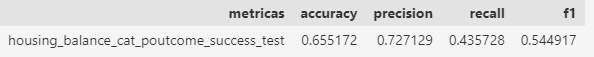

La primera tabla són los resultados con el 100% del Dataset (lo que acabamos de calcular) y la segunda con un 80% de datos del Sprint 9.2. Vemos que para el entrenamiento con todos los registros, baja en general un par de puntos sobre 100 excepto en recall, que es tan solo un 1,2 menos.

In [233]:
#Los coeficientes del modelo son
# Mostrar los coeficientes del modelo
print("Socoring precisión:", round(precision,3))
print("Coeficientes:", modelo_regres_logistica.coef_)
print("Intercepto:", modelo_regres_logistica.intercept_)


Socoring precisión: 0.707
Coeficientes: [[-0.67374002  0.23253587  2.40081756]]
Intercepto: [0.03372992]


**Guardar el modelo entrenado y el escalador**

In [234]:
#  Guardar el modelo y el escalador en archivos .pkl
# Guardar el modelo entrenado
with open('modelo_regres_logistica.pkl', 'wb') as model_file:
    pickle.dump(modelo_regres_logistica, model_file)

# Guardar el escalador
with open('scaler_regres_logistica.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

print("Modelo y escalador guardados como 'modelo_regres_logistica.pkl' y 'scaler_regres_logistica.pkl'.")

Modelo y escalador guardados como 'modelo_regres_logistica.pkl' y 'scaler_regres_logistica.pkl'.
